# Modelo de contagem

Este módulo tem como objetivo Carregar uma imagem aerea de grande dimensões, subdividir em janelas, utilizar essas janelas como entrada de um modelo de detecção de vacas e por fim contabilizar as vacas detectadas em cada janela e fornecer a quantidade total de vacas na imagem.

##  Importar os módulos

In [1]:
import os
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from ultralytics import YOLO

## 1 - Declarar Funções

In [2]:
def createNameImage(paths_image):
    name_format = paths_image.split("\\")[-1]
    image_name=name_format.split(".")[0] 
    
    return image_name

#Cria uma Lista com o Nome de todas as imagens no path de entrada 
def createListNameImageFiles(input_path):

    from pathlib import Path
    images = Path(input_path).glob("*.jpg")
    image_names_list = [str(p) for p in images]

    return image_names_list



# Esta função recebe um path da imagem, carrega e retorna uma imagem BGR 
def loadImage(IMAGE_PATH):
    print("Carregando imagem " + IMAGE_PATH)
    imagem = cv2.imread(IMAGE_PATH)
    
    return imagem

# Esta função recebe uma imagem e realiza a vizualização
def showImage(imagem):
    print("Visualizando a imagem...")
    plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
    plt.show()
    
# Esta função recebe o caminho do modelo e carrega e retorna um modelo yolo de detecção de objetos
def loadYOLOModel(MODEL_PATH):
    model = YOLO(MODEL_PATH)
    print("Carregando modelo de detecção YOLO " + MODEL_PATH)
    return model

# Esta função recebe uma imagem e as dimenções de largura e altura das janelas. Por fim,retorna um vetor de janelas dessa imagem
def generateWindows(imagem_orig, WIN_WIDTH, WIN_HEIGHT):
    altura, largura, canal = imagem_orig.shape
    
    n_largura = int(largura/WIN_WIDTH)
    n_altura = int(altura/WIN_HEIGHT)
    
    
    i = 1
    x1 = 0
    y1 = 0
    x2 = WIN_WIDTH
    y2 = WIN_HEIGHT
    
    windows_vetor = []
    
    for a in range(n_altura):
        for l in range(n_largura):
            
            #img_draft = cv2.rectangle(imagem_orig, (x1, y1), (x2, y2), (255,0,0), 4)
            #showImage(img_draft)
            windows_img = imagem_orig[y1:y2, x1:x2]
            windows_vetor.append(windows_img)
            #showImage(windows_img)
            
            
            i = i + 1
            x1 = x1 + WIN_WIDTH
            x2 = x2 + WIN_WIDTH
            l = l + 1           
        
        x1 = 0
        y1 = y2
        x2 = WIN_WIDTH
        y2 = y2 + WIN_HEIGHT
        a = a + 1

    return windows_vetor

# Esta função recebe uma imagem em janela, ID da janela, o modelo de detecção e o valor threshold para realizar a detecção e
# contagem dos objetos existentes na janela. Por fim, retorna o numero de vacas detectadas na janela e também retorna um 
# um Dataframe com a posição das detecções.

def detectAndCountWindows(win_image, win_ID, model, DETECTION_THRESHOLD):
    frame = win_image
    results = model(win_image, verbose=False)[0]
    
    class_name_dict = {0: 'cow', 1:'noCow'}
    
    cow_number = 0
    
    row_list = []
    
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
            
        if int(class_id) != 0:
            pass

        else:

            if score > DETECTION_THRESHOLD:
                cow_number = cow_number + 1
                
                #cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                #cv2.putText(frame, class_name_dict[int(class_id)].upper()+"_"+str(round(score)*100)+"%", (int(x1), int(y1 - 10)),
                 #           cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

                value = [win_ID, 'cow', x1, y1, x2, y2, score]
                row_list.append(value)

                #plt.imshow(frame)
                #plt.show()
                

    column_name = ['win_ID', 'classe', 'x1', 'y1', 'x2', 'y2', 'scores']
    detections_df = pd.DataFrame(row_list, columns=column_name)
                
    return cow_number, detections_df

# Esta função recebe o vetor de janelas, o modelo e o threshold. Em seguida, Retorna a contagem total de vacas e um Dataframe 
# com as posições
def countingCows(windows_vetor, model, DETECTION_THRESHOLD):
    
    win_ID = 0
    vetor_qt_cows = []
    
    row_list = []
    column_name = ['win_ID', 'classe', 'x1', 'y1', 'x2', 'y2', 'scores']
    final_detection_df = pd.DataFrame(row_list, columns=column_name)
    
    for win_image in windows_vetor:
        
        cow_number, detections_df = detectAndCountWindows(win_image, win_ID, model, DETECTION_THRESHOLD)
        
        vetor_qt_cows.append(cow_number)
        final_detection_df = pd.concat([final_detection_df, detections_df])
        
        win_ID = win_ID + 1
        
        
    qt_cows = sum(vetor_qt_cows)
    
    return qt_cows, final_detection_df.reset_index(drop=True)

def convetBBoxWinToBBoxOrig(win_x1, win_y1, win_x2, win_y2, win_ID, WIN_WIDTH, WIN_HEIGHT, n_largura, n_altura):
    
    i = 0
    x1 = 0
    y1 = 0
    x2 = WIN_WIDTH
    y2 = WIN_HEIGHT
    
    windows_vetor = []
    
    for a in range(n_altura):
        for l in range(n_largura):
            
            if i == win_ID:
                orig_x1 = x1 + win_x1
                orig_y1 = y1 + win_y1
                orig_x2 = x1 + win_x2
                orig_y2 = y1 + win_y2
                
                return orig_x1, orig_y1, orig_x2, orig_y2

            
            
            i = i + 1
            x1 = x1 + WIN_WIDTH
            x2 = x2 + WIN_WIDTH
            l = l + 1           
        
        x1 = 0
        y1 = y2
        x2 = WIN_WIDTH
        y2 = y2 + WIN_HEIGHT
        a = a + 1
    
    
    return orig_x1, orig_y1, orig_x2, orig_y2

def writeNumCow(image, qt_total_cow):
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX

    # org
    org = (100, 200)

    # fontScale
    fontScale = 5

    # Blue color in BGR
    color = (0, 255, 0)

    # Line thickness of 2 px
    thickness = 10

    # Using cv2.putText() method
    image = cv2.putText(image, "Numero de Vacas: " + str(qt_total_cow), org, font, 
                       fontScale, color, thickness, cv2.LINE_AA)
    
    return image
    
    
def printDetections(imagem_orig, qt_cows, final_detection_df, WIN_WIDTH, WIN_HEIGHT):
    
    altura, largura, canal = imagem_orig.shape
    
    n_largura = int(largura/WIN_WIDTH)
    n_altura = int(altura/WIN_HEIGHT)
    
    
    n_detections = len(final_detection_df)
    for i in range(n_detections):
        
        win_ID = final_detection_df.iloc[i][0]
        classe = final_detection_df.iloc[i][1]
        win_x1 = final_detection_df.iloc[i][2]
        win_y1 = final_detection_df.iloc[i][3]
        win_x2 = final_detection_df.iloc[i][4]
        win_y2 = final_detection_df.iloc[i][5]
        score = final_detection_df.iloc[i][6]
        
        x1, y1, x2, y2 = convetBBoxWinToBBoxOrig(win_x1, win_y1, win_x2, win_y2, win_ID, WIN_WIDTH, WIN_HEIGHT, n_largura, n_altura)

        cv2.rectangle(imagem_orig, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 10)
        cv2.putText(imagem_orig, classe + "_" + str(i+1), (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 0), 8, cv2.LINE_AA)
        
    
    writeNumCow(imagem_orig, qt_cows)
    showImage(imagem_orig)
    

## 2 - Configurações 

In [3]:
DATASET_ORIG_PATH = "C:\\NEW_TCC\\dataset\\validacao"
IMAGEM_ORIG_PATH = os.path.join(DATASET_ORIG_PATH, "cow365.JPG")
MODEL_PATH = os.path.join('.', 'runs', 'detect', 'train2', 'weights', 'best.pt')
OUTPUT_COUNTING_PATH = "C:\\NEW_TCC\\output\\modulo_contagem"

WIN_WIDTH = 500
WIN_HEIGHT = 600
DETECTION_THRESHOLD = 0.75

# Contagem

Carregando imagem C:\NEW_TCC\dataset\validacao\cow365.JPG
Visualizando a imagem...


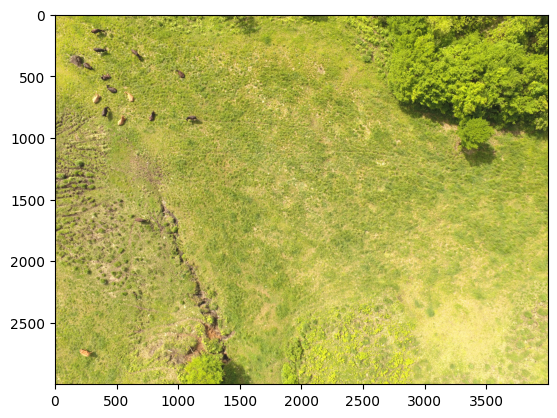

Carregando modelo de detecção YOLO .\runs\detect\train2\weights\best.pt
Visualizando a imagem...


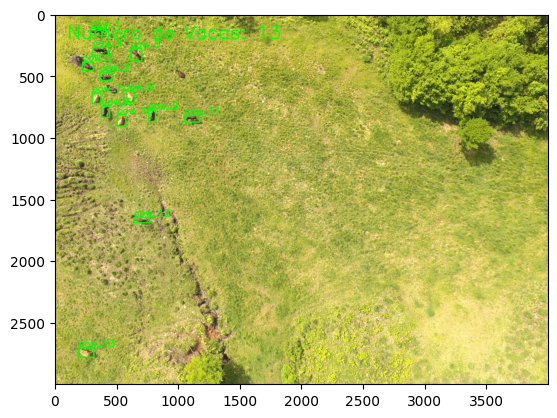

Visualizando a imagem...


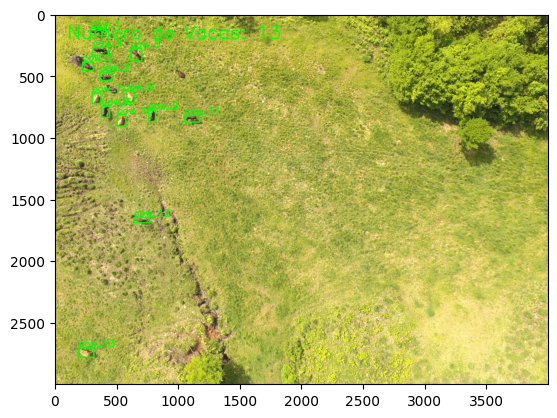

In [4]:
imagem_orig = loadImage(IMAGEM_ORIG_PATH) 
showImage(imagem_orig)
model = loadYOLOModel(MODEL_PATH)

windows_vetor = generateWindows(imagem_orig, WIN_WIDTH, WIN_HEIGHT)

qt_cows, final_detection_df = countingCows(windows_vetor, model, DETECTION_THRESHOLD)

printDetections(imagem_orig, qt_cows, final_detection_df, WIN_WIDTH, WIN_HEIGHT)

showImage(imagem_orig)